<a href="https://colab.research.google.com/github/aioakiddnh/udemy_lecture_pytorch/blob/master/section2/simple_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなディープラーニング
PyTorchを使って簡単なディープラーニングを実装します。  
今回は、ディープラーニングにより手書き文字の認識を行います。


### 手書き文字画像の確認
scikit-learnから、手書き数字の画像データを読み込んで表示します。  

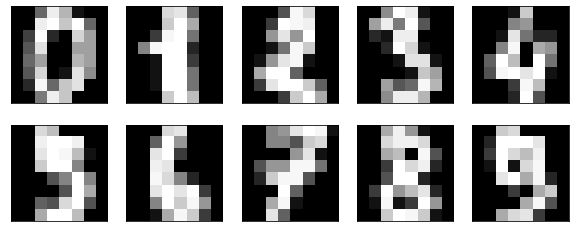

データの形状: (1797, 64)
ラベル: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits() # scikit-learnから手書き文字のデータセットを読み込む

n_img = 10 # 表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
  ax = plt.subplot(2, 5, i+1) # 2行5列で表示する。i+1は表示位置。
  plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
  ax.get_xaxis().set_visible(False) # 軸を非表示に
  ax.get_yaxis().set_visible(False)
plt.show()

print("データの形状:", digits_data.data.shape)
print("ラベル:", digits_data.target[:n_img])

データの形状: (1797, 64)　：　1797枚の画像が入っている。8×8は横が8で縦が8の画像。
それぞれの画像には0～9までのラベルがついている。

8×8とサイズは小さいですが、0から9までの手書き数字の画像が表示されました。このような手書き数字の画像が、このデータセットには1797枚含まれています。  
また、各画像は描かれた数字を表すラベルとペアになっています。  



## データを訓練用とテスト用に分割
scikit-learnのtrain_test_splitを使って、データを訓練用とテストに分割します。

In [ ]:
import torch # PyTorch
from sklearn.model_selection import train_test_split

digit_images = digits_data.data # digits_dataから画像データを読み込む
labels = digits_data.target # digits_dataからラベルを読み込む
# 画像データとラベルを分割。
# x_train：訓練用の入力、x_test：テスト用の入力、t_train：訓練用の正解、t_test：テスト用の正解
# 分割する理由は、訓練用全てのデータに最適化してしまうと、訓練用データの範囲に無いデータに適用できないかもしれない。
# 訓練用データに過剰に適用してしまう過学習が起こる可能性がある。それが起きてない事を確認するためにテスト用データを用意しておく。
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels) # 25%がテスト用（train_test_splitは特に設定をしないと、全体の25%がテスト用になる。）

# 上記の状態ではnumpyの配列であるため、Tensorに変換する。（PyTorchで扱う際にはTensorに変換する必要がある。）
x_train = torch.tensor(x_train, dtype=torch.float32) # 入力は小数に変換
t_train = torch.tensor(t_train, dtype=torch.int64) # 正解は整数に変換
x_test = torch.tensor(x_test, dtype=torch.float32) # 入力は小数に変換
t_test = torch.tensor(t_test, dtype=torch.int64) # 正解は整数に変換

## モデルの構築
`nn`モジュールの`Sequential`クラスによりモデルを構築します。

In [ ]:
from torch import nn # torchのnnをインポート

# nnのSequentialを使う。nnは直線状に様々な層が並んだモデルを作る時に非常に便利な機能。
# Sequentialの引数として各層を渡すだけでモデルを作る事が出来る。
net = nn.Sequential( # netという名前のモデルを構築。
    nn.Linear(64, 32), # 全結合層 # 1つ入力に近い層とすべて接続されている層のこと。 # 入力の形状は8×8で64 次の中間層の入力が32になる。
    nn.ReLU(), # 活性化関数 ReLU
    nn.Linear(32, 16), # 中間層の入力が32、次の出力層の入力が16。
    nn.ReLU(),
    nn.Linear(16, 10) # 出力層の入力が16、出力層の出力が10。今回は0～9の10のクラスに分類するため、最後の層のニューロン数は10。
)
print(net) # モデルをprintすることで、どのような構成か表示できる。

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
今回は、損失関数に交差エントロピー誤差を、最適化アルゴリズムにSGD（確率的勾配降下法）を設定します。  
順伝播は訓練データ、テストデータ両者で行い誤差を計算します。  
逆伝播を行うのは、訓練データのみです。  


In [ ]:
from torch import optim # torchからoptimをインポート

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD # 最適化アルゴリズムはoptimから取り出せる。
# SGDクラスでSGDを実装することが出来る。パラメータと学習率を設定する必要がある。
# さきほどのnetモデルのパラメータを渡し、lr(learning rate)を0.01に設定。
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ(記録)
record_loss_train = [] # 訓練用のデータを使って計算した損失
record_loss_test = [] #テスト用のデータを使って計算した損失

# 1000エポック学習 # 順伝播・逆伝播をしてパラメータを1回更新することを1エポックという。
for i in range(1000):

  # 勾配を0に設定 # これが無いと勾配が累積されてしまうため、ループごとに勾配を0にする必要がある。
  optimizer.zero_grad()

  # 順伝播 # モデル名の後に()をつけて入力を渡せばそれだけで順伝播が行える。
  y_train = net(x_train)
  y_test = net(x_test)

  # 誤差を求める
  loss_train = loss_fnc(y_train, t_train) # 出力と正解を渡す。
  loss_test = loss_fnc(y_test, t_test) # 出力と正解を渡す。
  record_loss_train.append(loss_train.item()) # それぞれを格納。後程グラフとして表示。 # tensorの数値を取り出す場合にはitem()が必要。
  record_loss_test.append(loss_test.item()) # それぞれを格納。後程グラフとして表示。 # tensorの数値を取り出す場合にはitem()が必要。

  # 逆伝播（勾配を求める）
  loss_train.backward()

  # 勾配に基づいてパラメータの更新
  optimizer.step()

  # 100エポックごとにエポック数と誤差を表示
  if i%100 == 0:
    print("Epoc:", i, "Loss_Train:", loss_train.item(), "Loss_Test:", loss_test.item())

Epoc: 0 Loss_Train: 2.4968719482421875 Loss_Test: 2.5003201961517334
Epoc: 100 Loss_Train: 1.1244996786117554 Loss_Test: 1.1369291543960571
Epoc: 200 Loss_Train: 0.5099847316741943 Loss_Test: 0.5284117460250854
Epoc: 300 Loss_Train: 0.3162534832954407 Loss_Test: 0.341306209564209
Epoc: 400 Loss_Train: 0.22530518472194672 Loss_Test: 0.2604508399963379
Epoc: 500 Loss_Train: 0.17313776910305023 Loss_Test: 0.21875660121440887
Epoc: 600 Loss_Train: 0.13903872668743134 Loss_Test: 0.19302791357040405
Epoc: 700 Loss_Train: 0.11540261656045914 Loss_Test: 0.17583921551704407
Epoc: 800 Loss_Train: 0.09815742075443268 Loss_Test: 0.16337887942790985
Epoc: 900 Loss_Train: 0.084940105676651 Loss_Test: 0.15478545427322388


## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

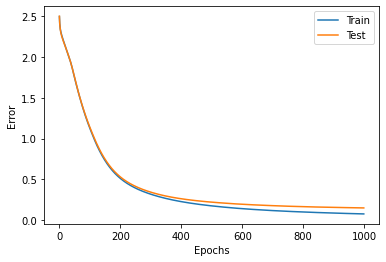

In [ ]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train") # x軸はデータの数、rangeで0からデータの数-1まで並べる。y軸はrecord_loss_trainそのまま
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test") # x軸はデータの数、rangeで0からデータの数-1まで並べる。y軸はrecord_loss_testそのまま
plt.legend() # 凡例表示

plt.xlabel("Epochs") # X軸凡例
plt.ylabel("Error") # Y軸凡例
plt.show()

訓練誤差、テスト誤差共に滑らかに減少している。
もし、テスト誤差が訓練誤差と大きく離れていたら、過学習が起きている。

## 正解率
モデルの性能を把握するため、テストデータ使いこのモデルは何%正解出来るのかという正解率を測定します。  

In [ ]:
y_test = net(x_test) # テスト用の入力を使って順伝播を行い、出力を計算する。この出力はどのクラス（数字）である確率が最も高いかを表す。

# 最も確率の高い確率の数字をargmaxを用いて取り出す。
# それが正解（t_test）と等しければTrueを返す。
# Trueの数をsum()を使って数える。
# item()でそれを数値に直す。
count = (y_test.argmax(1) == t_test).sum().item() 

print("正解率:", str(count/len(y_test)*100) + "%")

正解率: 95.11111111111111%


## 訓練済みのモデルを使った予測
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

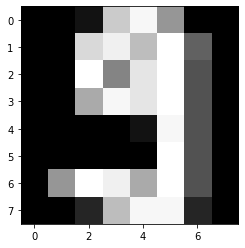

正解: 9 予測結果: 9


In [ ]:
# 適当な画像を取り出して表示するコード
# 全画像データの中の128番目の画像を表示
img_id = 128
x_pred = digit_images[img_id]
image = x_pred.reshape(8, 8)
plt.imshow(image, cmap="Greys_r")
plt.show()

# それを入力として予測を行う
x_pred = torch.tensor(x_pred, dtype=torch.float32)
y_pred = net(x_pred)
print("正解:", labels[img_id], "予測結果:", y_pred.argmax().item())

このような訓練済みのモデルは、別途保存しWebアプリなどで活用することができます。